In [2]:
def letterbox(im, new_shape=(416, 416), color=(114, 114, 114), 
                auto=True, scaleup=True, stride=32):
    """
    Resize and pad the image while meeting stride-multiple constraints.

    Args:
        im (numpy.ndarray): The input image.
        new_shape (int or tuple): The desired new shape of the image. If an integer is provided, the image will be resized to a square with that side length.
        color (tuple): The RGB color value for the padding. Default is (114, 114, 114).
        auto (bool): Whether to use the minimum rectangle for padding. Default is True.
        scaleup (bool): Whether to allow scaling up of the image. If set to False, the image will only be scaled down. Default is True.
        stride (int): The stride value for the stride-multiple constraint. Default is 32.

    Returns:
        tuple: A tuple containing the resized and padded image (numpy.ndarray), the scale ratio (float), and the padding values (tuple).
    """
    
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

In [5]:
def object_detection(model_path, img_path, names):
    """
    Perform object detection on an image using an ONNX model.

    Args:
        model_path (str): The path to the ONNX model file.
        img_path (str): The path to the input image file.
        names (list): A list of class names for the detected objects.

    Returns:
        PIL.Image.Image: The modified image with bounding boxes and labels.
    """
    session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])

    colors = {name: [random.randint(0, 255) for _ in range(3)] for i, name in enumerate(names)}

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    image = img.copy()
    image, ratio, dwdh = letterbox(image, auto=False)
    image = image.transpose((2, 0, 1))
    image = np.expand_dims(image, 0)
    image = np.ascontiguousarray(image)

    im = image.astype(np.float32)
    im /= 255

    outname = [i.name for i in session.get_outputs()]

    inname = [i.name for i in session.get_inputs()]

    inp = {inname[0]: im}

    # ONNX inference
    outputs = session.run(outname, inp)[0]
    ori_images = [img.copy()]

    for i, (batch_id, x0, y0, x1, y1, cls_id, score) in enumerate(outputs):
        image = ori_images[int(batch_id)]
        box = np.array([x0, y0, x1, y1])
        box -= np.array(dwdh * 2)
        box /= ratio
        box = box.round().astype(np.int32).tolist()
        cls_id = int(cls_id)
        score = round(float(score), 2)
        name = names[cls_id]
        color = colors[name]
        name += ' ' + str(score)
        cv2.rectangle(image, box[:2], box[2:], color, 2)
        cv2.putText(image, name, (box[0], box[1] - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [225, 255, 255], thickness=2)

    return Image.fromarray(ori_images[0])


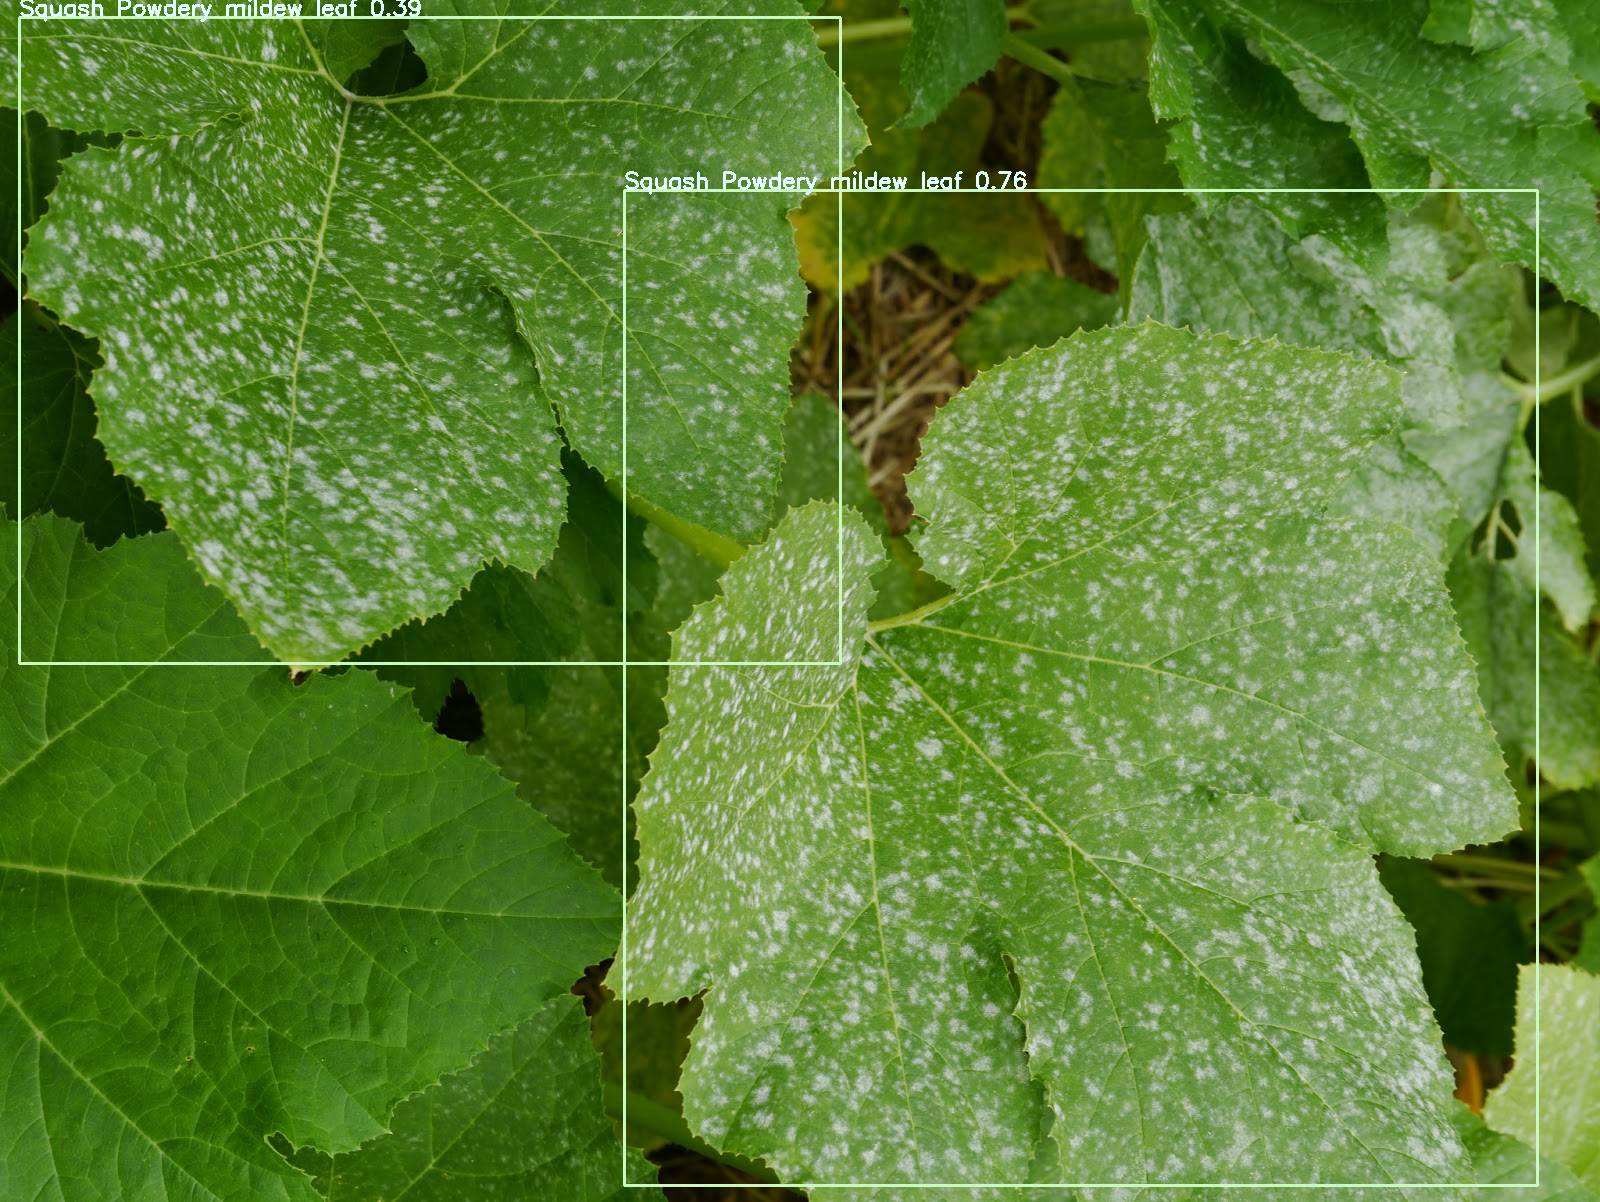

In [1]:
from detect import object_detection

model_path = "yolov7/best.onnx"
img_path = 'yolov7/3.jpg'
names = ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf spot',
         'Bell_pepper leaf', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot',
         'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight',
         'Potato leaf late blight', 'Potato leaf', 'Raspberry leaf', 'Soyabean leaf',
         'Soybean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf',
         'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot',
         'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus',
         'Tomato leaf', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf',
         'grape leaf black rot', 'grape leaf']

result_image = object_detection(model_path, img_path, names)
result_image
